<a href="https://colab.research.google.com/github/alvitay/Face-Emotion-Recognition/blob/main/Facial_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Emotion Detection  - Deep Learning <BR>**





## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>



## **Mounting the Drive**



In [1]:
# Mouts the drive from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [2]:
# There are several libraries we will mount, but more libraries will be added in the code as we proceede and as needed.
# It is generaly a good idea to mount only those libraries that either fit heavy lifting of the code or those that are used across the whole project
# Libraries that are used sporadically can be loaded "ad-hoc" when needed. These are the most used libraries for DeepLearning projects:

# Importing Data Science Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import rich
from PIL import Image
import zipfile

# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

# sklearn libraries
from sklearn.model_selection import train_test_split


### **Let us load the data**

In [14]:
# Define the path to your .zip file and where you want to extract it
zip_file_path = "/content/drive/MyDrive/Facial Recognition/Facial_emotion_images.zip"
extract_path = "/content/drive/MyDrive/Facial Recognition/Facial_emotion_images/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
# Now use the extracted folder path in your ImageVisualizer
folder_path = extract_path # Changed this line from folder_path = extract_path

In [16]:
import os
import zipfile

# Define the path to your .zip file and where you want to extract it
zip_file_path = "/content/drive/MyDrive/Facial Recognition/Facial_emotion_images.zip"
extract_path = "/content/drive/MyDrive/Facial Recognition/" # Changed this line

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Now use the extracted folder path in your ImageVisualizer
folder_path = extract_path + "Facial_emotion_images" # Changed this line

## **Visualizing our Classes**

Let's look at our 4 categories: Happy, Sad, Neutral and Surprise.

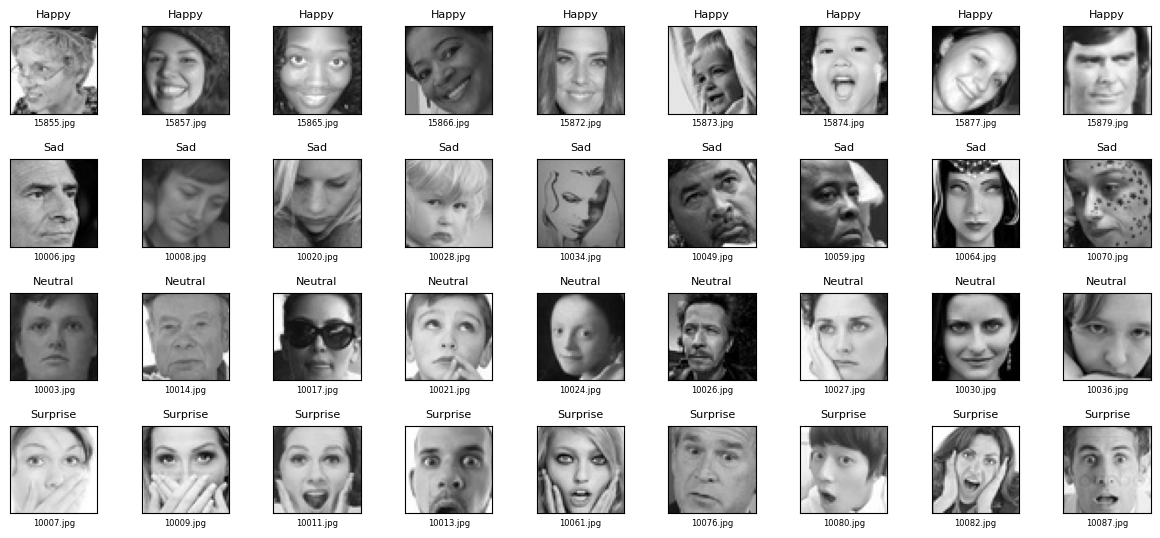

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image

class ImageVisualizer:
    def __init__(self, folder_path, categories, picture_size=48):
        self.folder_path = folder_path
        self.categories = categories
        self.picture_size = picture_size

    def visualize_images(self):
        # Set up a square grid to display 9 images from each category
        num_categories = len(self.categories)
        grid_size = int(np.ceil(np.sqrt(num_categories)))
        plt.figure(figsize=(12, 12))

        for i, category in enumerate(self.categories):
            # Get the list of image files in the current category folder
            category_path = os.path.join(self.folder_path, "train", category)
            image_files = os.listdir(category_path)

            # Ensure there are at least 9 images available
            num_images = min(len(image_files), 9)

            # Display up to 9 images from each category in a 3x3 grid
            for j in range(1, num_images + 1):
                plt.subplot(9, 9, i * 9 + j)
                plt.title(category.capitalize(), fontsize=8)

                # Build the full file path
                file_path = os.path.join(category_path, image_files[j - 1])

                # Remove axis ticks and labels
                plt.xticks([]), plt.yticks([])

                # Display the name of the picture underneath
                plt.xlabel(os.path.basename(file_path), fontsize=6)

                # Load and show the image inside the grid
                img = load_img(file_path, target_size=(self.picture_size, self.picture_size))
                image = Image.open(file_path)

                # Convert the image to a NumPy array
                image_array = np.array(image)

                # Display the image within the current subplot
                plt.imshow(img)

        # Adjust spacing and show the grid on screen
        plt.tight_layout()
        plt.show()

# Example usage
categories = ["happy", "sad", "neutral", "surprise"]
visualizer = ImageVisualizer(folder_path, categories)
visualizer.visualize_images()


In [18]:
import os

# Path to the validation set
validation_dir = os.path.join(folder_path, "validation")

# Check the number of images in each class folder
for category in os.listdir(validation_dir):
    category_path = os.path.join(validation_dir, category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f"Found {num_images} images in {category_path}")


Found 1825 images in /content/drive/MyDrive/Facial Recognition/Facial_emotion_images/validation/happy
Found 1216 images in /content/drive/MyDrive/Facial Recognition/Facial_emotion_images/validation/neutral
Found 1139 images in /content/drive/MyDrive/Facial Recognition/Facial_emotion_images/validation/sad
Found 797 images in /content/drive/MyDrive/Facial Recognition/Facial_emotion_images/validation/surprise


## **Checking Distribution of Classes**

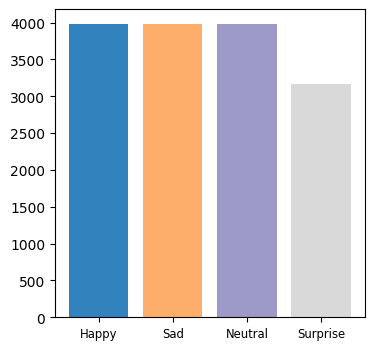

In [20]:
# Use list comprehension to calculate the number of images in each folder
num_happy, num_sad, num_neutral, num_surprise = [len(os.listdir(folder_path + f"/train/{emotion}")) for emotion in ['happy', 'sad', 'neutral', 'surprise']]
# Defines the graph window size in inches on the screen
plt.figure(figsize=(4, 4))
# Transfers the data into a dictionary so we can import it into a handy pandas Series
data = {'Happy': num_happy, 'Sad': num_sad, 'Neutral': num_neutral, 'Surprise': num_surprise}
# Puts the data into a pandas Series
df = pd.Series(data)
# Get a rainbow color map
colors = plt.cm.tab20c(np.linspace(0, 1, len(df)))
# Plots the bars with rainbow colors
bars = plt.bar(range(len(df)), df.values, align='center', color=colors)
# Assigns the values from the index of the dataframe as Legend items on the axis
plt.xticks(range(len(df)), df.index.values, size='small')
# Show the graph on the screen
plt.show()

**Observations and Insights:**<br>
The number of all pictures in the first categories is around 4000, however we have almost 800 pictures missing in the "surprise" category. Typically this could represent an issue, however before doing any testing, my feeling is that because this category "surprise" might be easier to identify as opposed the other ones, the data might actually not suffer from the lack of images. This is just speculation and if proved wrong, we will need to use models using Transfer Learning Architecture to give a "crutch" to our model.
<br><br>
As mentioned before, the "surprise" category is identified by a very specific shape of the mouth, which the other categories dont have. It is an "O" shape.
<br><br>
We will see how it performs during model training.

<a name="data-loaders"></a>
## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

In [22]:
#*********************
# This test is with grayscale images.
#*********************
# If we had unlimited computing power we would need a very simple Data Loader or even none.
# However, Data Loaders help tremendously in creating batches of data to be then sent to the CPU for processing,
# helping with processing load, data augmentation, preprocessing, dealing with data with different datasets and shuffling.

# Let's set the batch size to 32. So there will be 32 images sent to the CPU for processing at any given time.
# It is crucial not to overload the CPU of the processing machine to avoid the machine to hang or worse, crash!
# Python offers a library to monitor machine-side specific features. We could use psutil.cpu_percent() to see if the load is acceptable.
batch_size  = 32

# Lets set the image size
img_size = 48

# Let's create an ImageDataGenerator for data augmentation during training.
# In Keras an ImageDataGenerator is a utility class that helps with real-time data augmentation during the training of models on image data.
# It generates augmented images while the model is being trained, providing a diverse set of training examples,
# to improve the model's ability to generalize to new data.
datagen_train = ImageDataGenerator(
    # Flips images horizontally to increase diversity in the training set.
    horizontal_flip=True,

    # Varies the brightness of images to make the model more robust to lighting conditions.
    brightness_range=(0., 2.),

    # Rescales pixel values to be in the range [0, 1]. This is a common preprocessing step.
    rescale=1./255,

    # Applies shear transformations to the images, introducing deformation.
    shear_range=0.3)


# Creates a generator for training data using the configured ImageDataGenerator (datagen_train) with the augmentation.
train_set = datagen_train.flow_from_directory(
    # This is the path to our train folder
    folder_path + "/train",
    # Sets the target size to which all images will be resized during loading.
    target_size = (img_size, img_size),
    # Specifies the color mode of the images (e.g., "rgb" for color images).
    # We are going to try this first and see how it performs, and the also try grayscale.
    color_mode = "grayscale",
    # Sets the batch size, which determines the number of images processed in each iteration.
    batch_size = batch_size,
    # Specifies the class mode for categorical classification (e.g., one-hot encoded labels).
    class_mode = 'categorical',
    # Turns shuffle to True to shuffle the images in each Epoch. This is usually abetter training paradigm than just using images in a sequence.
    shuffle = True
    )

# Rescales pixel values to be in the range [0, 1].
datagen_validation = ImageDataGenerator(rescale=1./255)


# Let's create a generator for validation data using the configured ImageDataGenerator (datagen_validation).
validation_set = datagen_validation.flow_from_directory(
    # Our path to the validation data directory.
    folder_path + "/validation",

    # Sets the target size to which all images will be resized during loading (48 in our case).
    target_size=(img_size, img_size),

    # Specifies the color mode of the images (we are doing this in RGB the other grayscale model will follow).
    color_mode="grayscale",

    # Sets the batch size, which determines the number of images processed in each iteration (we set it to 32).
    batch_size=batch_size,

    # Specifies the class mode for categorical classification
    class_mode='categorical',

    # Shuffles the validation data. Shuffling helps improve model generalization during training.
    shuffle=True
)

# Creates an ImageDataGenerator for test data with rescaling as the only transformation.
datagen_test = ImageDataGenerator(rescale=1./255)

# Creates a generator for test data using the configured ImageDataGenerator (datagen_test).
test_set = datagen_test.flow_from_directory(
    #The path to the test data directory.
    folder_path + "/test",

    # Sets the target size to which all images will be resized during loading (48 in this case).
    target_size=(img_size, img_size),

    # Specifies the color mode of the images (as above using the RGB mode now).
    color_mode="grayscale",

    # Sets the batch size, determining the number of images processed in each iteration (32).
    batch_size=batch_size,

    # Specifies the class mode for categorical classification
    class_mode='categorical',

    # Shuffles the test data. Shuffling may help ensure unbiased evaluation.
    shuffle=True
)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


Let's create a Final CNN model. It is a simpler model


Tthis model consists of three sets of convolutional layers followed by max-pooling and batch normalization. The flattened output is then passed through a dense layer before the final output layer for classification.

First line adds a **2D convolutional layer** with 32 filters, each of size (3,3), using the ReLU activation function.
The input shape is set to (48,48,1), indicating a grayscale image with dimensions 48x48 pixels.

In the next line a **2D max-pooling layer** is added with a pool size of (2,2), reducing the spatial dimensions of the previous layer by half.

A **batch normalization layer** is added, which normalizes the activations of the previous layer to improve training stability.

Follows the **same set 32 filters**

Follows another **layer with 128 filters**.

So far the activation function was ReLU.

Then a new layer is added, **flatten layer**, converting the 3D output to a 1D vector, preparing it for the fully connected layers.

Next a **fully connected (dense) layer** is added with 128 neurons and a ReLU activation function.

And another **fully connected layer is added with 4 fully connected neurons** The **final dense layer** a softmax activation function is suitable for multi-class classification.

It is a relatively simple model but it has proven to be the most effective with high Accuracy.





In [23]:
# Let's create a sequential model, which is a linear stack of layers
finalmodel = Sequential([

    # Adds a 2D convolutional layer with 32 filters, each of size (3,3), using the ReLU activation function
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),

    # Adds a 2D max-pooling layer with a pool size of (2,2) to reduce spatial dimensions
    MaxPooling2D(2,2),

    # Adds batch normalization to normalize and stabilize activations
    BatchNormalization(),

    # Adds another 2D convolutional layer with 64 filters and ReLU activation
    Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1)),

    # Adds another 2D max-pooling layer
    MaxPooling2D(2,2),

    # Adds batch normalization
    BatchNormalization(),

    # Adds a third 2D convolutional layer with 128 filters and ReLU activation
    Conv2D(128, (3,3), activation='relu', input_shape=(48,48,1)),

    # Adds another 2D max-pooling layer
    MaxPooling2D(2,2),

    # Adds batch normalization
    BatchNormalization(),

    # Flattens the 3D output to a 1D vector for the fully connected layers
    Flatten(),

    # Adds a dense (fully connected) layer with 128 neurons and ReLU activation
    Dense(128, activation='relu'),

    # Adds the final dense layer with 4 neurons and softmax activation for 4 classes: happy, sad, neutral, angry
    Dense(4, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Let's see the summary of this model:

In [24]:
#Model summary
finalmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 23, 23, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,356 (1.36 MB)

 Trainable params: 355,908 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
# Compiles the model with the specified optimizer, loss function, and metrics for training
finalmodel.compile(

    # Uses the RMSprop optimizer with a learning rate of 0.001
    optimizer=RMSprop(learning_rate=0.001),

    # Uses categorical crossentropy as the loss function for multi-class classification
    loss='categorical_crossentropy',

    # Monitors accuracy as a metric during training
    metrics=['accuracy']
)


In [26]:
# Specifies the file name for the best model
file_name = "best_model.keras"

# Creates the full file path by joining the directory 'checkpoint' and the file name
checkpoint_path = os.path.join('checkpoint', file_name)


In [27]:
# Create a ModelCheckpoint callback
call_back = ModelCheckpoint(
    filepath=checkpoint_path,   # File path where the model checkpoints will be saved
    monitor='val_accuracy',     # Metric to monitor for saving the best model (validation accuracy in this case)
    verbose=1,                   # Verbosity level (1 for progress updates, 0 for silent)
    save_freq='epoch',           # Frequency of saving checkpoints (here, once per epoch)
    save_best_only=True,         # Save only the best models based on the monitored metric
    save_weights_only=False,     # Save the entire model, not just the weights
    mode='max'                   # Mode for determining the best model ('max' for maximizing the monitored metric)
)


This is the first run, below I performed a second run.

In [28]:
# Trains the model using the fit method
history = finalmodel.fit(
    train_set,                   # Training dataset
    epochs=20,                   # Number of training epochs
    callbacks=call_back,         # Callbacks, including ModelCheckpoint for saving the best model
    validation_data=validation_set  # Validation dataset
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


466/473 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.4183 - loss: 1.7210
Epoch 1: val_accuracy improved from -inf to 0.52923, saving model to checkpoint/best_model.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 95s 186ms/step - accuracy: 0.4195 - loss: 1.7139 - val_accuracy: 0.5292 - val_loss: 1.0909
Epoch 2/20
466/473 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6042 - loss: 0.9403
Epoch 2: val_accuracy improved from 0.52923 to 0.65441, saving model to checkpoint/best_model.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 87s 181ms/step - accuracy: 0.6043 - loss: 0.9401 - val_accuracy: 0.6544 - val_loss: 0.8603
Epoch 3/20
466/473 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6461 - loss: 0.8479
Epoch 3: val_accuracy improved from 0.65441 to 0.65923, saving model to checkpoint/best_model.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 143s 184ms/step - accuracy: 0.6462 - loss: 0.8477 - val_accuracy: 0.6592 - val_loss: 0.9110
Epoch 4/20
466/473 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6886 - loss: 0.7452
E

Lets run the same model again and see if we can achieve even higher Accuracy.

In [29]:
# Let's try the model again and see if it improves.
history = finalmodel.fit(
    train_set,
    epochs=20,
    callbacks = call_back,
    validation_data=validation_set,
)

Epoch 1/20
466/473 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8885 - loss: 0.2986
Epoch 1: val_accuracy did not improve from 0.72132
473/473 ━━━━━━━━━━━━━━━━━━━━ 87s 182ms/step - accuracy: 0.8884 - loss: 0.2988 - val_accuracy: 0.6926 - val_loss: 1.2060
Epoch 2/20
466/473 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8967 - loss: 0.2764
Epoch 2: val_accuracy did not improve from 0.72132
473/473 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.8966 - loss: 0.2766 - val_accuracy: 0.7030 - val_loss: 1.4827
Epoch 3/20
466/473 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8942 - loss: 0.2800
Epoch 3: val_accuracy did not improve from 0.72132
473/473 ━━━━━━━━━━━━━━━━━━━━ 85s 177ms/step - accuracy: 0.8942 - loss: 0.2800 - val_accuracy: 0.6994 - val_loss: 1.0759
Epoch 4/20
466/473 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8925 - loss: 0.2860
Epoch 4: val_accuracy did not improve from 0.72132
473/473 ━━━━━━━━━━━━━━━━━━━━ 141s 176ms/step - accuracy: 0.8925 - loss: 0.2859 - val

Lets evaluate the mode:

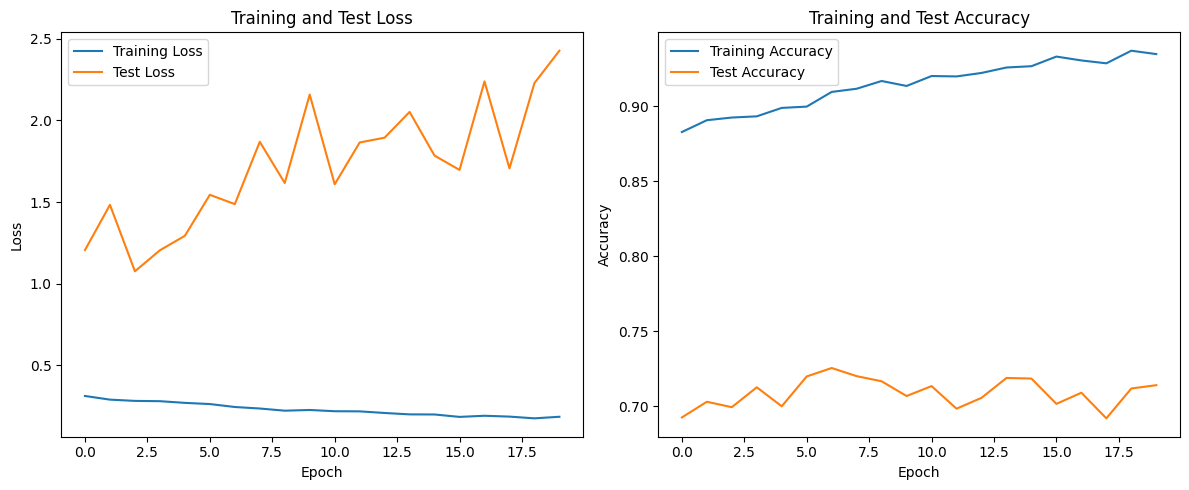

In [30]:
# Let's take a look at the accuracy and loss of our model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# We can use the .predict method to make our predictions.
test_pred = finalmodel.predict(test_set)

test_pred = np.argmax(test_pred, axis = -1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


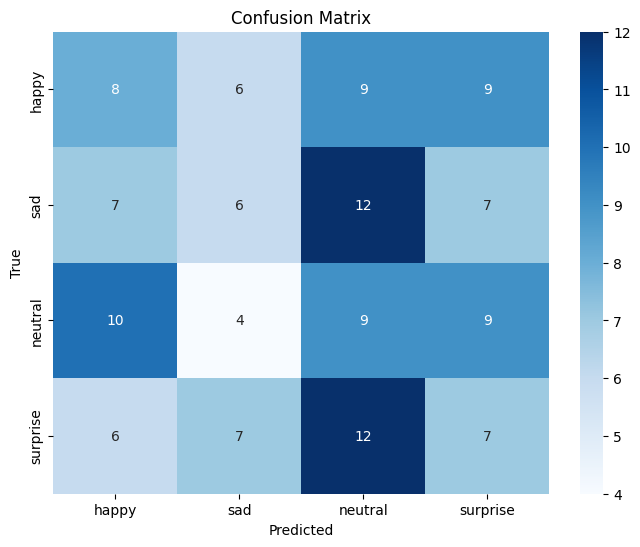

              precision    recall  f1-score   support

           0       0.26      0.25      0.25        32
           1       0.26      0.19      0.22        32
           2       0.21      0.28      0.24        32
           3       0.22      0.22      0.22        32

    accuracy                           0.23       128
   macro avg       0.24      0.23      0.23       128
weighted avg       0.24      0.23      0.23       128



In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate predictions on the test set
predictions = finalmodel.predict(test_set)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels for the test set
true_classes = test_set.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['happy', 'sad', 'neutral', 'surprise'], yticklabels=['happy', 'sad', 'neutral', 'surprise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(true_classes, predicted_classes))


### **Creating the Base Neural Network**

Let's creat a Base CNN model.
Our foundational neural network adopts a relatively straightforward architectural design.
<br><br>
* For the base neural network structure, we aim to incorporate three convolutional blocks. Each of these blocks is expected to comprise a Conv2D layer, a subsequent max-pooling layer, and a Dropout layer, offering flexibility to experiment with dropout ratios.

* Begin by introducing the initial Conv2D layer featuring 64 filters and a kernel size of 2. Utilize 'same' padding and set the input_shape to (48, 48, 3) for 'rgb' color mode in the dataloader or (48, 48, 1) for 'grayscale' colormode. Employ the 'relu' activation function.

* Subsequently, include a MaxPooling2D layer with a pool size of 2, followed by a Dropout layer with a dropout ratio of 0.2.

* Integrate a second Conv2D layer equipped with 32 filters and a kernel size of 2. Apply 'same' padding and 'relu' activation. Follow this with a corresponding MaxPooling2D layer and a Dropout layer featuring a 0.2 dropout ratio to finalize the second Convolutional Block.

* Add a third Conv2D layer featuring 32 filters and a kernel size of 2. Once again, utilize 'same' padding and 'relu' activation. Sequentially, include a MaxPooling2D layer and a Dropout layer to complete the third Convolutional Block.

* Upon incorporation of the convolutional blocks, introduce a Flatten layer.

* Follow this with the addition of the initial Dense layer, consisting of 512 neurons, and utilizing the 'relu' activation function.

* Insert a Dropout layer with a dropout ratio of 0.4.

* Conclude with the inclusion of the final Dense layer comprising 4 neurons and utilizing the 'softmax' activation function.

* Finally, print the summary of your model.

In [33]:
# We are working with RGB so our input shape will have 3 layers of 48x48 pixels pictures.
# (The grayscale model will only have 1 layer)
input_shape = (48, 48, 3)

# Creates the Sequential model
model = Sequential()

# First Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Second Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Third Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Flattens Layer
model.add(Flatten())

# Fully Connected Layers using relu as activation, Dropout is 0.4
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes (happy, sad, neutral, surprise)

# Prints model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 605,572 (2.31 MB)

 Trainable params: 605,572 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

### **Compiling and Training the Model**

In [35]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=(0., 2.),
    shear_range=0.3
)

# Make sure the color_mode is set to "grayscale" in your generators
train_set = datagen_train.flow_from_directory(
    folder_path + "/train",
    target_size=(48, 48),
    color_mode="grayscale",  # Ensure grayscale input (1 channel)
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_set = datagen_validation.flow_from_directory(
    folder_path + "/validation",
    target_size=(48, 48),
    color_mode="grayscale",  # Ensure grayscale input (1 channel)
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


In [36]:
# Modify the input shape of the first Conv2D layer to accept RGB images (3 channels)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),  # Input shape for RGB images
    MaxPooling2D(pool_size=(2, 2)),
    # ... other layers
])


In [37]:
# We are working with RGB so our input shape will have 3 layers of 48x48 pixels pictures.
# If you are using grayscale images, set the last dimension to 1
input_shape = (48, 48, 1)

# Creates the Sequential model
model = Sequential()

# First Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Second Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Third Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Flattens Layer
model.add(Flatten())

# Fully Connected Layers using relu as activation, Dropout is 0.4
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes (happy, sad, neutral, surprise)

# Prints model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 64)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 605,060 (2.31 MB)

 Trainable params: 605,060 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Before complining the Model, we should also set checkpoints to help us with training.
# Defines a model checkpoint to save the best model based on validation accuracy.
checkpoint = ModelCheckpoint("./model1.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Implements early stopping to halt training if validation loss stops improving after a certain number of epochs.
# This can save a lot of time.
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
    )

# Reduces learning rate if validation loss plateaus, promoting convergence during training.
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
    )

# Compiles the list of callbacks to be utilized during model training.
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# Sets the number of training epochs.
epochs = 20

# Compiles the model.
model.compile(
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['accuracy']  # Monitors accuracy during training
)

# Let's train the model and fit it by following the outcome. Let's try 20 Epochs.

epochs = 20
# Fits the model
history = model.fit(
    train_set,  # Training set
    epochs=epochs,
    validation_data=validation_set,  # Your validation dataset
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


473/473 ━━━━━━━━━━━━━━━━━━━━ 138s 192ms/step - accuracy: 0.2833 - loss: 1.3821 - val_accuracy: 0.4569 - val_loss: 1.2646
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 92s 179ms/step - accuracy: 0.4068 - loss: 1.2788 - val_accuracy: 0.5180 - val_loss: 1.1365
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.4657 - loss: 1.1960 - val_accuracy: 0.5584 - val_loss: 1.0570
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.5140 - loss: 1.1093 - val_accuracy: 0.5779 - val_loss: 1.0042
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 88s 184ms/step - accuracy: 0.5223 - loss: 1.0816 - val_accuracy: 0.6004 - val_loss: 0.9621
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 83s 173ms/step - accuracy: 0.5443 - loss: 1.0411 - val_accuracy: 0.6295 - val_loss: 0.9137
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 87s 182ms/step - accuracy: 0.5675 - loss: 1.0106 - val_accuracy: 0.6261 - val_loss: 0.9052
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 86s 180ms/step - accuracy: 0.5670 - loss: 0.9903 - va

### **Evaluating the Model on the Test Set**

In [39]:
# Let's evaluate the model. It collects all the metrics and combines them together to computer performance. The output is a python list.
evaluation_result = model.evaluate(test_set)

# Print the evaluation result (loss and accuracy)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

# Previously we compiled our model with loss and accuracy only, but other metrics are available.
#    'precision'
#    'recall'
#    'f1_score'
#    'confusion_matrix'

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6115 - loss: 0.8304
Test Loss: 0.7373253703117371
Test Accuracy: 0.6484375


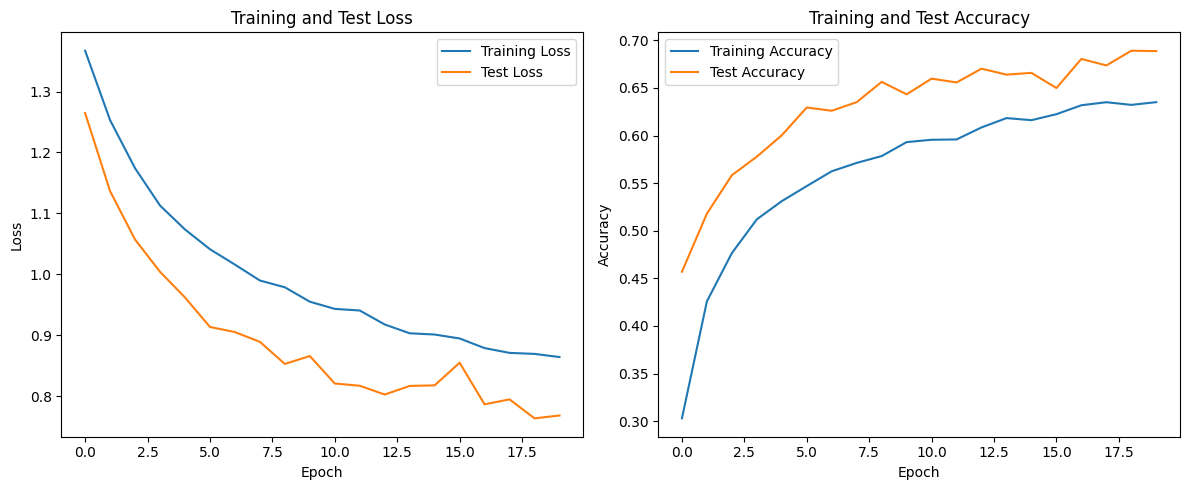

In [40]:
# Let's take a look at the accuracy and loss of our model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Observations and Insights:**
**Loss Graph:**

Training Loss (Blue):<br>
- Starts at a high value (around 1.38) and gradually decreases over epochs.<br>
- Reaches 0.88 by epoch 20, indicating a certain minimization of training loss.<br>
- The decreasing trend suggests that the model is learning and adjusting its parameters however slowly.<br>

Test Loss (Yellow):<br>
- Starts at a lower value (around 1.28) compared to training loss.<br>
- Follows a similar decreasing trend, reaching almost 0 by epoch 20.<br>
- The slight divergence of training and test loss suggests that the model is somewhat overfitting.<br>

**Accuracy Graph:**

Training Accuracy (Blue):<br>
- Starts at a relatively low value (around 0.30) and increases steadily over epochs.<br>
- Reaches 0.60 by epoch 20, indicating improved classification on training data.<br>

Test Accuracy (Yellow):<br>
- Starts at a higher value (around 0.44) compared to training accuracy.<br>
- Shows a zig-zag pattern, possibly indicating fluctuations in performance.<br>
- Reaches 0.68 by epoch 20, suggesting somewhat improved generalization.<br>

**Insights:**

- Overall the model is learning, as indicated by decreasing training and test loss.<br>
- Training and test accuracy show improvement, though test accuracy has some fluctuations sugggesting overfitting.<br>
- The zig-zag pattern in test accuracy should be investigated; it might be related to learning rate or dataset characteristics.<br>
- Further analysis, including precision, recall, and the confusion matrix, can provide deeper insights.<br>
- Maybe fine-tuning hyperparameters or adjusting model complexity for stability during training might improbe the model.<br>


### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Flatten, Dense

input_shape = (48, 48, 3)

# Create the Sequential model
model2 = Sequential()

# First Convolutional Block
model2.add(Conv2D(256, kernel_size=2, padding='same', input_shape=input_shape))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))

# Second Convolutional Block
model2.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))

# Third Convolutional Block
model2.add(Conv2D(64, kernel_size=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))

# Fourth Convolutional Block
model2.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))

# Flattens Layer
model2.add(Flatten())

# Fully Connected Layers
model2.add(Dense(512, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))  # Assuming 4 classes (happy, sad, neutral, surprise)

# Prints model summary
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 256)         │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 6, 6, 32)            │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 6, 6, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         147,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 391,652 (1.49 MB)

 Trainable params: 390,692 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

### **Compiling and Training the Model**

In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Defines EarlyStopping callback. This will stop after 5 Epochs if there is no improvement in val_loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Defines ReduceLROnPlateau callback, it will stop after 3 Epochs.
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.0001)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint("./model2.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Combines all callbacks into a list
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [43]:
# Compiles the model2
model2.compile(
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['accuracy']  # Monitors accuracy during training
)


In [44]:
input_shape = (48, 48, 1) # Change the last value from 3 to 1

# Create the Sequential model
model2 = Sequential()

# First Convolutional Block
model2.add(Conv2D(256, kernel_size=2, padding='same', input_shape=input_shape)) # The input_shape variable has changed
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))

# ... rest of your model

In [45]:
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))
# Compiles the model2
model2.compile(
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['accuracy']  # Monitors accuracy during training
)

epochs = 20
# Let's Fit the model
history = model2.fit(
    train_set,  # Our training dataset
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch. It will give us more information during the process
    validation_data = validation_set  # Our validation dataset
)

Epoch 1/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3894 - loss: 3.8040
Epoch 1: val_loss improved from inf to 1.27021, saving model to ./model2.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 89s 179ms/step - accuracy: 0.3896 - loss: 3.7962 - val_accuracy: 0.4963 - val_loss: 1.2702 - learning_rate: 0.0010
Epoch 2/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5059 - loss: 1.1551
Epoch 2: val_loss did not improve from 1.27021
473/473 ━━━━━━━━━━━━━━━━━━━━ 137s 173ms/step - accuracy: 0.5058 - loss: 1.1551 - val_accuracy: 0.2604 - val_loss: 2.8101 - learning_rate: 0.0010
Epoch 3/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5115 - loss: 1.1493
Epoch 3: val_loss did not improve from 1.27021
473/473 ━━━━━━━━━━━━━━━━━━━━ 86s 181ms/step - accuracy: 0.5115 - loss: 1.1494 - val_accuracy: 0.2729 - val_loss: 2.9969 - learning_rate: 0.0010
Epoch 4/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5294 - loss: 1.1245
Epoch 4: val_loss improved from 1.27021 to

### **Evaluating the Model on the Test Set**

In [46]:
# Let's evaluate the model. It collects all the metrics and combines them together to computer performance. The output is a python list.
evaluation_result = model2.evaluate(test_set)

# Prints the evaluation result (loss and accuracy)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5667 - loss: 1.0555
Test Loss: 0.9759745597839355
Test Accuracy: 0.5859375


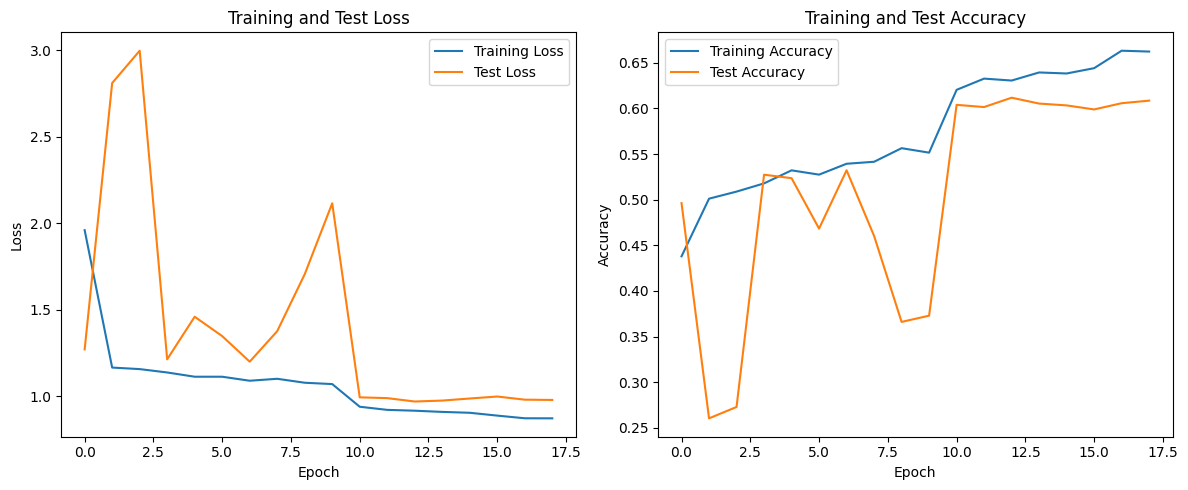

In [47]:
# Let's take a look at the accuracy and loss of our model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Observations and Insights:**<br><br>
**Training and Test Loss Graph:**
<br><br>
**Training Loss (Blue):<br>**
Initiates at 1.38 and steadily decreases to 0.55 by epoch 20, indicating some  improvement in minimizing training loss.<br>
The smoother decline suggests that the model is learning more efficiently compared to the previous scenario.<br><br>
**Test Loss (Yellow):<br>**

Starts at 1.22 and exhibits a decreasing trend, reaching 0.7 by epoch 20.<br>
The reduction in test loss is notable, though the "bouncing" on training line persists, indicating potential overfitting.<br>
Despite improvement, monitoring overfitting is crucial for better generalization.<br>
<br>
**Accuracy Graph:**
<br><br>
**Training Accuracy (Blue):<br>**

Commences at 0.40 and shows a consistent upward trend, reaching 0.79 by epoch 20.<br>
The substantial improvement in training accuracy suggests enhanced classification performance on the training set.<br><br>
**Test Accuracy (Yellow):**<br>
<br>
Starts at 0.42 and gradually increases to 0.69 but exhibits a zigzag pattern thereafter, indicating potential instability.<br>
The initial improvement in generalization is observed, but the subsequent fluctuations suggest overfitting or sensitivity to certain patterns.<br>
While there is improvement, attention is needed to mitigate the potential negative effects of overfitting on the test accuracy.<br>
<br><br>

**Insights:**

Significant improvement is noted in both training and test loss, indicating enhanced learning efficiency.<br>
Training accuracy exhibits a smooth upward trajectory, showcasing improved classification on the training data.<br>
The zigzag pattern in test accuracy, especially after an initial improvement, raises concerns about potential overfitting or sensitivity to specific patterns.<br>
Further investigation into the cause of the zigzag pattern and measures to address overfitting, such as regularization techniques, would be beneficial.<br>
Fine-tuning hyperparameters and monitoring for stability during training are crucial for optimizing the model's performance.<br>






#**Let's try the same extended CNN but with only GRAYSCALE data.**<br>
The hypothesis is that grayscale data will fit better into our classification problem.

In [49]:
#*********************
# This test is with GRAYSCALE color images.
#*********************
# This new data loader is essentially the same as before but we are just changing the 3 channels RGB to one GRAYSCALE.
# Most of the commenting has been removed for brevity since it is already well commented in the data loader before.
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(0., 2.),
    rescale=1./255,
    shear_range=0.3)

train_set = datagen_train.flow_from_directory(
    folder_path + "/train",
    target_size = (img_size, img_size),
    color_mode = "grayscale",
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
    )

datagen_validation = ImageDataGenerator(rescale=1./255)

validation_set = datagen_validation.flow_from_directory(
    folder_path + "/validation",
    target_size=(img_size, img_size),
    color_mode= "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

datagen_test = ImageDataGenerator(rescale=1./255)
test_set = datagen_test.flow_from_directory(
    folder_path + "/test",
    target_size=(img_size, img_size),
    color_mode= "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Flatten, Dense

input_shape = (48, 48, 1) # <-------Changed to one channel only grayscale

# Create the Sequential model
modelGray = Sequential()

# First Convolutional Block
modelGray.add(Conv2D(256, kernel_size=2, padding='same', input_shape=input_shape))
modelGray.add(BatchNormalization())
modelGray.add(LeakyReLU(alpha=0.1))
modelGray.add(MaxPooling2D(pool_size=2))

# Second Convolutional Block
modelGray.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
modelGray.add(BatchNormalization())
modelGray.add(LeakyReLU(alpha=0.1))
modelGray.add(MaxPooling2D(pool_size=2))

# Third Convolutional Block
modelGray.add(Conv2D(64, kernel_size=2, padding='same', activation='relu'))
modelGray.add(BatchNormalization())
modelGray.add(LeakyReLU(alpha=0.1))
modelGray.add(MaxPooling2D(pool_size=2))

# Fourth Convolutional Block
modelGray.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
modelGray.add(BatchNormalization())
modelGray.add(LeakyReLU(alpha=0.1))
modelGray.add(MaxPooling2D(pool_size=2))

# Flattens Layer
modelGray.add(Flatten())

# Fully Connected Layers
modelGray.add(Dense(512, activation='relu'))
modelGray.add(Dense(128, activation='relu'))
modelGray.add(Dense(4, activation='softmax'))  # Assuming 4 classes (happy, sad, neutral, surprise)

# Prints model summary
modelGray.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 48, 48, 256)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 24, 24, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 6, 6, 32)            │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 6, 6, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         147,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 389,604 (1.49 MB)

 Trainable params: 388,644 (1.48 MB)

 Non-trainable params: 960 (3.75 KB)

In [51]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Defines EarlyStopping callback. This will stop after 5 Epochs if there is no improvement in val_loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Defines ReduceLROnPlateau callback, it will stop after 3 Epochs.
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.0001)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint("./grayscale.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Combines all callbacks into a list
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [52]:
# Compiles the model2
modelGray.compile(
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['accuracy']  # Monitors accuracy during training
)

In [53]:
epochs = 20
# Let's Fit the model
history = modelGray.fit(
    train_set,  # Our training dataset
    epochs=epochs,

    callbacks=callbacks_list,
    verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch. It will give us more information during the process

    validation_data = validation_set  # Our validation dataset
)

Epoch 1/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3428 - loss: 1.3723
Epoch 1: val_loss improved from inf to 1.34238, saving model to ./grayscale.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 146s 193ms/step - accuracy: 0.3430 - loss: 1.3719 - val_accuracy: 0.3369 - val_loss: 1.3424 - learning_rate: 0.0010
Epoch 2/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4643 - loss: 1.1581
Epoch 2: val_loss improved from 1.34238 to 1.09038, saving model to ./grayscale.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 142s 176ms/step - accuracy: 0.4644 - loss: 1.1579 - val_accuracy: 0.5240 - val_loss: 1.0904 - learning_rate: 0.0010
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5624 - loss: 1.0001
Epoch 3: val_loss improved from 1.09038 to 0.97693, saving model to ./grayscale.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 143s 177ms/step - accuracy: 0.5624 - loss: 1.0001 - val_accuracy: 0.5837 - val_loss: 0.9769 - learning_rate: 0.0010
Epoch 4/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 141m

In [54]:
# Let's evaluate the grayscale model.
evaluation_result = modelGray.evaluate(test_set)

# Prints the evaluation result (loss and accuracy)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6990 - loss: 0.7465
Test Loss: 0.7207933664321899
Test Accuracy: 0.671875


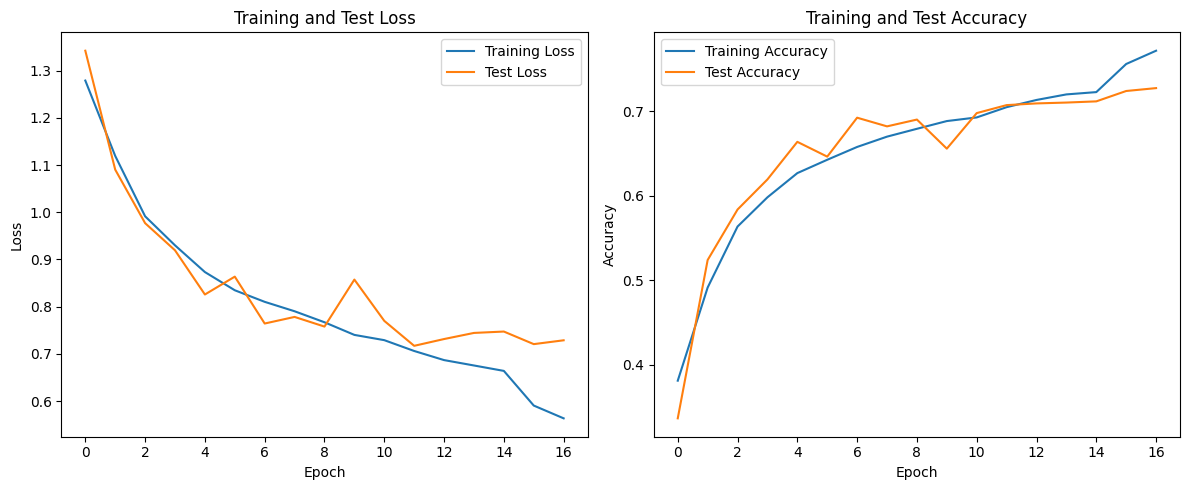

In [55]:
# Let's take a look at the accuracy and loss of our grayscale model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Observation:** Some improvement has been notice in the Grayscale model but not significant. The RGB and Grayscale options do not seem to make much difference except the grayscale model seems not to overfit a lot, compared to the RGB option.



## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [56]:
# New data loaders for RGB colors again. Essentially the rest of this code is identical to the first data loader which is commented.
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(
    horizontal_flip = True,
    brightness_range = (0., 2.),
    rescale = 1./255,
    shear_range = 0.3
    )

train_set = datagen_train.flow_from_directory(
    folder_path + "/train",
    target_size = (img_size, img_size),
    color_mode = 'rgb', # <---- back to RGB
    batch_size = batch_size,
    class_mode = 'categorical',
    classes = ['happy', 'sad', 'neutral', 'surprise'],
    shuffle = True
    )

datagen_validation = ImageDataGenerator(rescale = 1./255)

validation_set = datagen_validation.flow_from_directory(
    folder_path + "/validation",
    target_size = (img_size, img_size),
    color_mode = "rgb", # <---- back to RGB
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
    )


datagen_test = ImageDataGenerator(rescale=1./255)
test_set = datagen_test.flow_from_directory(
    folder_path + "/test",
    target_size = (img_size, img_size),
    color_mode = "rgb", # <---- back to RGB
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
    )


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

The VGG16 (Visual Geometry Group 16) model is a convolutional neural network architecture renowned for its simplicity and effectiveness in image classification tasks. Comprising 16 layers, including 13 convolutional and 3 fully connected layers, VGG16 utilizes small 3x3 filters and max pooling with 2x2 filters to learn complex features while maintaining spatial resolution. Rectified Linear Unit (ReLU) activation functions introduce non-linearity, and the architecture, pre-trained on datasets like ImageNet, is often used for transfer learning. With its modular design, the VGG16 model has made significant contributions to computer vision applications, although newer architectures have since surpassed it in performance.

Like other Transfer Learning Architectures, VGG models needs 3 channels, therefore we will use RGB in our data loader.





### **Importing the VGG16 Architecture**


In [57]:
# Lets import tyhe VGG16 architecture from Keras TensorFlow.
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [58]:
# Let's use the entire set of layers of the VGG16
transfer_layer = vgg.output
vgg.trainable = False
x = Flatten()(transfer_layer)
# Add classification layers on top of it
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred)  # Initializing the model
vggmodel.summary()

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,150,340 (57.79 MB)

 Trainable params: 435,524 (1.66 MB)

 Non-trainable params: 14,714,816 (56.13 MB)

### **Compiling and Training the VGG16 Model**

In [59]:
# Let's set up the checkpoints. The code is essentially the same as above.
checkpoint = ModelCheckpoint("./vggmodel.keras", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [60]:
# Let's compile the VGG16 model
vggmodel.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

In [61]:
epochs = 20
# Fits the model
history = vggmodel.fit(
    train_set,
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    validation_data=validation_set,
    callbacks=callbacks_list
)

Epoch 1/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.3414 - loss: 1.4216
Epoch 1: val_loss improved from -inf to 1.34332, saving model to ./vggmodel.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 145s 218ms/step - accuracy: 0.3416 - loss: 1.4212 - val_accuracy: 0.3016 - val_loss: 1.3433 - learning_rate: 0.0010
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4398 - loss: 1.2266
Epoch 2: val_loss did not improve from 1.34332
473/473 ━━━━━━━━━━━━━━━━━━━━ 158s 206ms/step - accuracy: 0.4398 - loss: 1.2266 - val_accuracy: 0.4135 - val_loss: 1.2422 - learning_rate: 0.0010
Epoch 3/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4688 - loss: 1.1817
Epoch 3: val_loss did not improve from 1.34332
473/473 ━━━━━━━━━━━━━━━━━━━━ 98s 204ms/step - accuracy: 0.4688 - loss: 1.1817 - val_accuracy: 0.3801 - val_loss: 1.2873 - learning_rate: 0.0010
Epoch 4/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4714 - loss: 1.1722
Epoch 4: val_loss did not improve from

### **Evaluating the VGG16 model**

In [62]:
evaluation_result = vggmodel.evaluate(test_set)

# Print the evaluation result (loss and accuracy)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3719 - loss: 1.3386
Test Loss: 1.2472193241119385
Test Accuracy: 0.4296875


**Observations and Insights:**
Generally speaking the performace was much worse compared to the non Transfer Learning architecture. Maybe a different Model like Resnet

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

ResNet, short for Residual Networks, is a groundbreaking deep neural network architecture designed to address the challenges of training very deep networks. Introduced by Kaiming He et al., ResNet's innovation lies in the incorporation of residual connections or skip connections that allow the network to bypass certain layers. These shortcuts enable the direct flow of information from one layer to another, mitigating the vanishing gradient problem and facilitating the training of extremely deep networks. ResNet architectures often come in variants like ResNet50 or ResNet101, indicating the number of layers. This design has proven highly effective in various computer vision tasks, winning the ImageNet Large Scale Visual Recognition Challenge in 2015 and serving as a foundation for subsequent state-of-the-art architectures.

In [63]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
# The test has also been performed with ResNet101 with very similar results.

Resnet = ap.ResNet50V2(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 12, 12, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 12, 12, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 14, 14, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# Let's try to train it on the entire set of layers
transfer_layer_Resnet = Resnet.output
Resnet.trainable = False

# Flattens the output from the ResNet model
x = Flatten()(transfer_layer_Resnet)

# Adds a Dense layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Adds a Dense Layer with 128 neurons
x = Dense(128, activation='relu')(x)

# Adds a Dropout layer with a dropout ratio of 0.3
x = Dropout(0.3)(x)

# Adds a Dense Layer with 64 neurons
x = Dense(64, activation='relu')(x)

# Adds a Batch Normalization layer
x = BatchNormalization()(x)

# Adds the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation='softmax')(x)

# Initializes the model
resnetmodel = Model(Resnet.input, pred)

### **Compiling and Training the Model**

In [65]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10

In [66]:
from tensorflow.keras.optimizers import Adam

# Compiles the model
resnetmodel.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [67]:
epochs = 20

# Fits the model
history = resnetmodel.fit(
    train_set,
    epochs=epochs,
    verbose=1,
    validation_data=validation_set,
    callbacks=callbacks_list
)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 118s 218ms/step - accuracy: 0.3508 - loss: 1.4310 - val_accuracy: 0.4314 - val_loss: 1.2097 - learning_rate: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


473/473 ━━━━━━━━━━━━━━━━━━━━ 97s 204ms/step - accuracy: 0.4470 - loss: 1.2176 - val_accuracy: 0.4346 - val_loss: 1.1931 - learning_rate: 0.0010
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 94s 196ms/step - accuracy: 0.4893 - loss: 1.1579 - val_accuracy: 0.4537 - val_loss: 1.2458 - learning_rate: 0.0010
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 96s 201ms/step - accuracy: 0.5180 - loss: 1.1093 - val_accuracy: 0.4328 - val_loss: 1.2233 - learning_rate: 0.0010
Epoch 5/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5223 - loss: 1.0963
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
473/473 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - accuracy: 0.5223 - loss: 1.0963 - val_accuracy: 0.4215 - val_loss: 1.2637 - learning_rate: 0.0010
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 143s 203ms/step - accuracy: 0.5427 - loss: 1.0563 - val_accuracy: 0.4485 - val_loss: 1.1938 - learning_rate: 2.0000e-04
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 140s 198ms/step - accuracy: 0.5696 -

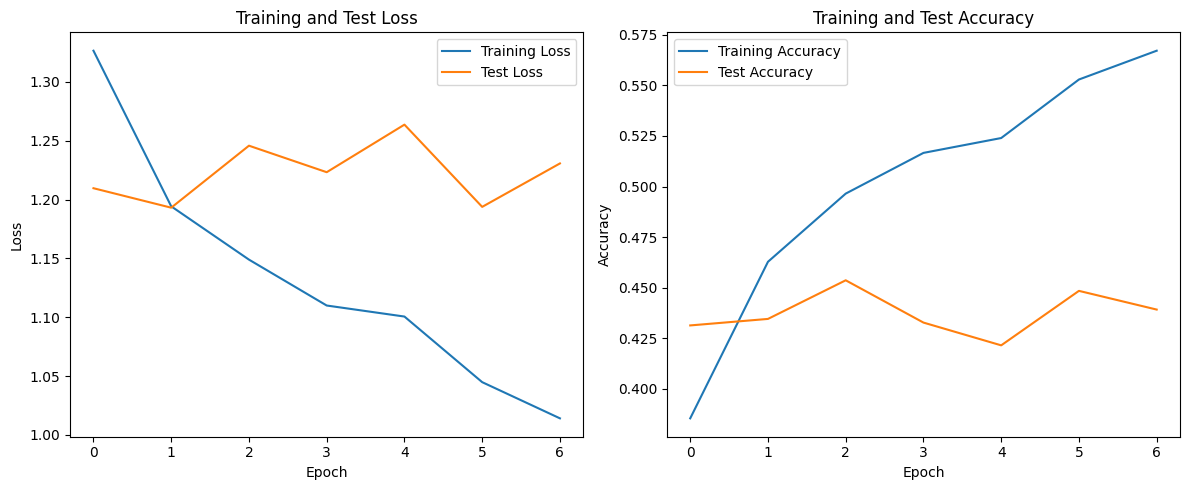

In [68]:
# Let's take a look at the accuracy and loss of our Resnet model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:


from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf # Imports tensorflow

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1).numpy() # Converts the tensor to a NumPy float

lr_schedule = LearningRateScheduler(scheduler)

epochs = 20

# Fit the model
history = resnetmodel.fit(
    train_set,
    epochs=epochs,
    verbose=1,
    validation_data=validation_set,
    callbacks=[lr_schedule]
    )

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 96s 201ms/step - accuracy: 0.5993 - loss: 0.9495 - val_accuracy: 0.4704 - val_loss: 1.2369 - learning_rate: 2.0000e-04
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 97s 204ms/step - accuracy: 0.6063 - loss: 0.9312 - val_accuracy: 0.4549 - val_loss: 1.2540 - learning_rate: 2.0000e-04
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 90s 189ms/step - accuracy: 0.6010 - loss: 0.9342 - val_accuracy: 0.4352 - val_loss: 1.3120 - learning_rate: 2.0000e-04
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 93s 194ms/step - accuracy: 0.6137 - loss: 0.9135 - val_accuracy: 0.4690 - val_loss: 1.3261 - learning_rate: 2.0000e-04
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 96s 200ms/step - accuracy: 0.6331 - loss: 0.8896 - val_accuracy: 0.4649 - val_loss: 1.3503 - learning_rate: 2.0000e-04
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 137s 191ms/step - accuracy: 0.6288 - loss: 0.8797 - val_accuracy: 0.4808 - val_loss: 1.2965 - learning_rate: 2.0000e-04
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 140s 

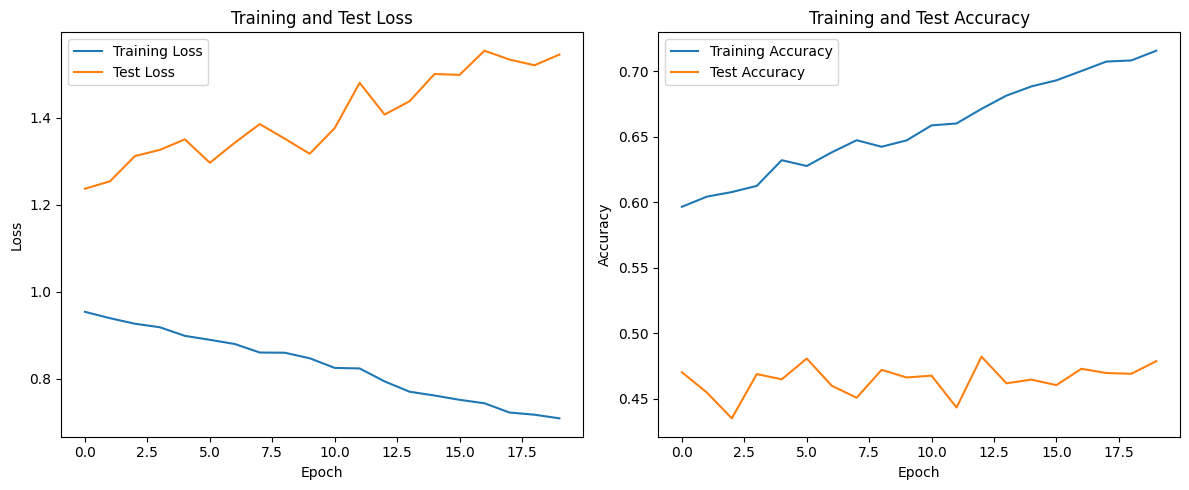

In [72]:
# Let's take a look at the accuracy and loss of our Resnet model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### **Evaluating the ResNet Model**

In [73]:
evaluation_result = resnetmodel.evaluate(test_set)

# Print the evaluation result (loss and accuracy)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5792 - loss: 1.3823
Test Loss: 1.4566751718521118
Test Accuracy: 0.53125


**Observations and Insights:**
Unfortunately even the Resnet architecture is still performing poorly. With or without adjustments to the learning rate



## **EfficientNet Model**

EfficientNet represents a family of neural network architectures designed for optimal efficiency in terms of both computational resources and model performance. Developed by Mingxing Tan and Quoc V. Le, EfficientNet introduces a novel compound scaling method that efficiently scales the model's depth, width, and resolution. This compound scaling allows the model to achieve superior performance with significantly fewer parameters compared to traditional methods. EfficientNet prioritizes model efficiency by balancing the trade-off between accuracy and computational cost, making it particularly suitable for resource-constrained environments. The architecture's success is evident in its impressive performance across various image classification tasks, demonstrating state-of-the-art results with a high level of efficiency. The EfficientNet family includes different variants denoted by a scaling factor (e.g., EfficientNet-B0, EfficientNet-B7), allowing users to choose models based on their specific computational constraints and performance requirements.


Used several variants, EfficientNetV2B2, EfficientNetB3 and B7 to see if training on a very large dataset will improve things.

In [74]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetV2B2

# Load the EfficientNetV2B2 model pre-trained on ImageNet data
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))
EfficientNet.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 48, 48, 3)      │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 48, 48, 3)      │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 32)     │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 24, 24, 16)     │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 24, 24, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 24, 24, 16)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 24, 24, 16)     │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 24, 24, 16)     │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 24, 24, 16)     │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 24, 24, 16)     │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 24, 24, 16)     │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├──────────────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [75]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# Load the EfficientNetB0 model pre-trained on ImageNet data

# Specify the layer from which you want to transfer
transfer_layer_EfficientNet = EfficientNet.output
# We could use the model partially by starting at a lowe lever with get_layer('block6e_expand_activation')
EfficientNet.trainable = False

# Add your Flatten layer.
x = Flatten()(transfer_layer_EfficientNet)

# Adding Dense layers and/or BatchNormalization and Dropout layers
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

# Adding your final Dense layer with 4 neurons and softmax activation function.
pred = Dense(4, activation='softmax')(x)

# Initializes the model
Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [76]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10

In [77]:
from keras.optimizers import Adam
# Compiles the model
Efficientnetmodel.compile(
    # Tried 0.001 and 0.0001 but the result is the same.
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [78]:
epochas = 20
batch_size = 32
history = Efficientnetmodel.fit(
    train_set,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=validation_set,
    callbacks=callbacks_list
)

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 178s 292ms/step - accuracy: 0.2504 - loss: 1.7313 - val_accuracy: 0.3671 - val_loss: 1.4078 - learning_rate: 1.0000e-04
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


473/473 ━━━━━━━━━━━━━━━━━━━━ 97s 203ms/step - accuracy: 0.2574 - loss: 1.5615 - val_accuracy: 0.2489 - val_loss: 1.5149 - learning_rate: 1.0000e-04
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 95s 199ms/step - accuracy: 0.2513 - loss: 1.5215 - val_accuracy: 0.2289 - val_loss: 1.5797 - learning_rate: 1.0000e-04
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 93s 196ms/step - accuracy: 0.2498 - loss: 1.4940 - val_accuracy: 0.2443 - val_loss: 1.4053 - learning_rate: 1.0000e-04
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 94s 196ms/step - accuracy: 0.2579 - loss: 1.4662 - val_accuracy: 0.2522 - val_loss: 1.3886 - learning_rate: 1.0000e-04
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 142s 198ms/step - accuracy: 0.2555 - loss: 1.4576 - val_accuracy: 0.2441 - val_loss: 1.4030 - learning_rate: 1.0000e-04
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 140s 195ms/step - accuracy: 0.2515 - loss: 1.4476 - val_accuracy: 0.2443 - val_loss: 1.4286 - learning_rate: 1.0000e-04
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 142s 195ms/step

### **Evaluating the EfficientnetNet Model**

In [79]:
evaluation_result = Efficientnetmodel.evaluate(test_set)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2948 - loss: 1.3827
Test Loss: 1.3853099346160889
Test Accuracy: 0.265625


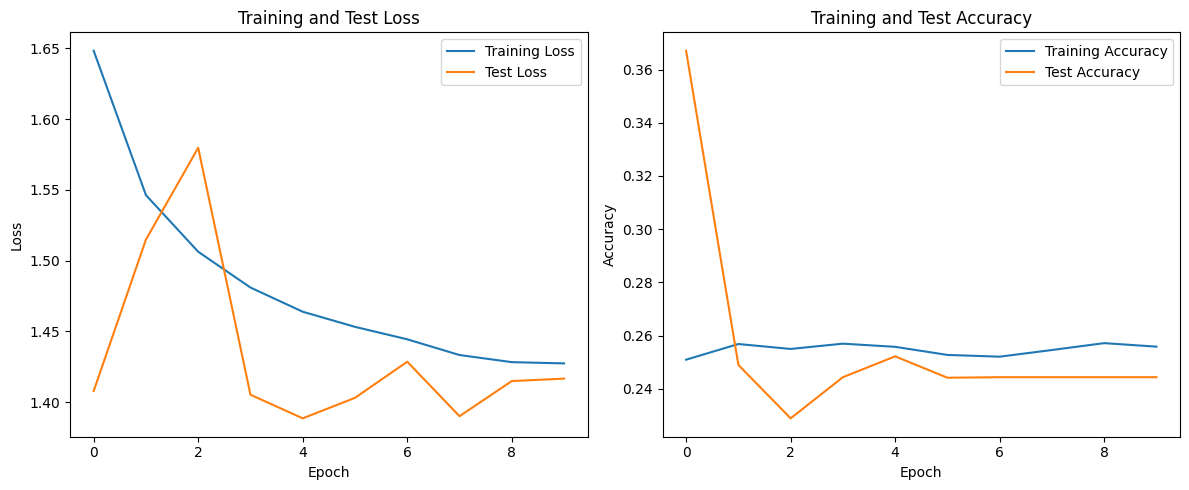

In [80]:
# Let's take a look at the accuracy and loss of our this model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Observations and Insights**
This model does not perform although there are 2 areas of concern:<br>
1. the model says in verbose mode: Can save best model only with val_acc available, skipping. I this this needs to be investigated and I might need to review the entire code for EfficientNet. Not sure if this a characteristic of this architecture or if I made a mistake.
<br>
2. The graphs plottes look funny too.

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [81]:
backend.clear_session()

In [82]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(0., 2.),
    rescale=1./255,
    shear_range=0.3)

train_set = datagen_train.flow_from_directory(
    folder_path + "/train",
    target_size = (img_size, img_size),
    color_mode = "grayscale", # <---- using grayscale because the images are grayscale, no reason to add additional layers.
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
    )

datagen_validation = ImageDataGenerator(rescale=1./255)

validation_set = datagen_validation.flow_from_directory(
    folder_path + "/validation",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

datagen_test = ImageDataGenerator(rescale=1./255)

test_set = datagen_test.flow_from_directory(
    folder_path + "/test",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

### **Compiling and Training the Model**

In [83]:
# We are working with Grayscale so our input shape will have 1 layer only of 48x48 pixels pictures.
# (The grayscale model will only have 1 layer)
input_shape = (48, 48, 1)

# Creates the Sequential model
model = Sequential()

# First Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Second Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Third Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Foutrh Convolutional Block pool of 2 and Dropout 0.2
model.add(Conv2D(16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Flattens Layer
model.add(Flatten())

# Fifth, Fully Connected Layers using relu as activation, Dropout is 0.4
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes (happy, sad, neutral, surprise)

# Prints model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 16)            │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,028 (355.58 KB)

 Trainable params: 91,028 (355.58 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# Before complining the Model, we should also set checkpoints to help us with training.
# Defines a model checkpoint to save the best model based on validation accuracy.
checkpoint = ModelCheckpoint("./modelCNN.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Implements early stopping to halt training if validation loss stops improving after a certain number of epochs.
# This can save a lot of time.
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
    )

# Reduces learning rate if validation loss plateaus, promoting convergence during training.
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
    )

# Compiles the list of callbacks to be utilized during model training.
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]


# Compiles the model.
model.compile(
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['accuracy']  # Monitor accuracy during training
)

# Lest train the model and fit it by followin the outcome. Let's try 20 Epochs.
epochs = 20
# Fits the model
history = model.fit(
    train_set,  # Training set
    epochs=epochs,
    validation_data=validation_set,  # Your validation dataset
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


473/473 ━━━━━━━━━━━━━━━━━━━━ 138s 182ms/step - accuracy: 0.2687 - loss: 1.3850 - val_accuracy: 0.3707 - val_loss: 1.3444
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 90s 177ms/step - accuracy: 0.2771 - loss: 1.3779 - val_accuracy: 0.3773 - val_loss: 1.3519
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.3270 - loss: 1.3434 - val_accuracy: 0.4428 - val_loss: 1.2404
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - accuracy: 0.3925 - loss: 1.2880 - val_accuracy: 0.4346 - val_loss: 1.2396
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 84s 175ms/step - accuracy: 0.4120 - loss: 1.2554 - val_accuracy: 0.4919 - val_loss: 1.1849
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 85s 178ms/step - accuracy: 0.4294 - loss: 1.2224 - val_accuracy: 0.5234 - val_loss: 1.1449
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 78s 162ms/step - accuracy: 0.4456 - loss: 1.2035 - val_accuracy: 0.5292 - val_loss: 1.1033
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 86s 179ms/step - accuracy: 0.4646 - loss: 1.1803 - va

### **Evaluating the Model on Test Set**

In [86]:
evaluation_result = model.evaluate(test_set)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5938 - loss: 0.8806
Test Loss: 0.8953702449798584
Test Accuracy: 0.5703125


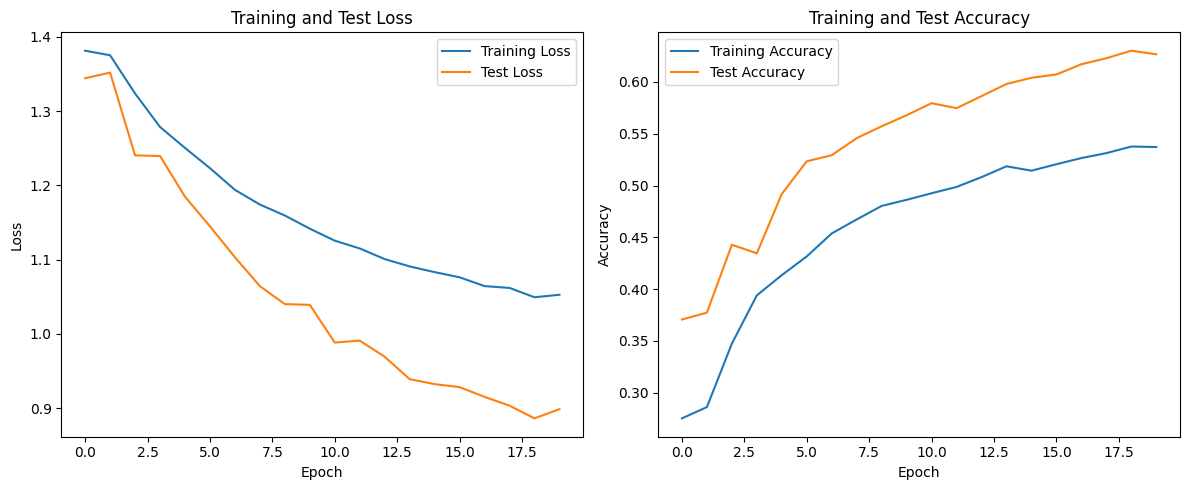

In [87]:
# Let's take a look at the accuracy and loss of our model and plot it.
# Extracts training history for loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracts test history
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

# Plots training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### **Plotting the Confusion Matrix for the chosen final model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


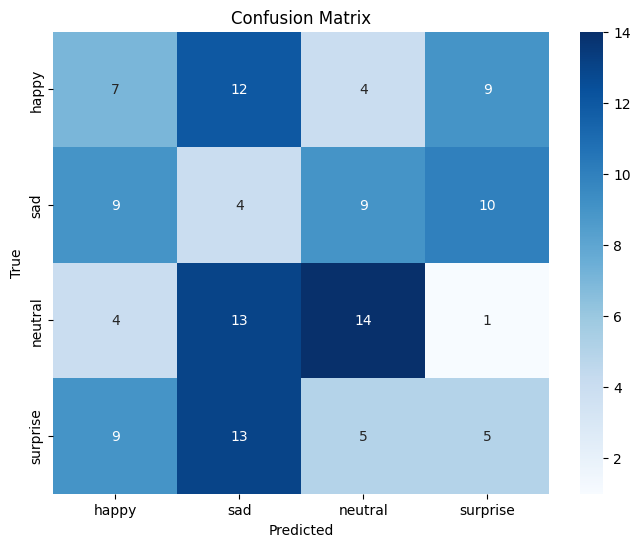

              precision    recall  f1-score   support

           0       0.24      0.22      0.23        32
           1       0.10      0.12      0.11        32
           2       0.44      0.44      0.44        32
           3       0.20      0.16      0.18        32

    accuracy                           0.23       128
   macro avg       0.24      0.23      0.24       128
weighted avg       0.24      0.23      0.24       128



In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Generate predictions
predictions = model.predict(test_set)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = test_set.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['happy', 'sad', 'neutral', 'surprise'], yticklabels=['happy', 'sad', 'neutral', 'surprise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(true_classes, predicted_classes))

**Observations and Insights:**

In [89]:
backend.clear_session()

# Fixing the seed for random number generators
import random
import tensorflow as tf

np.random.seed(42)

random.seed(42)

tf.random.set_seed(42)

In [90]:
import tensorflow.keras.applications as ap
from tensorflow.keras.applications import ResNet101
Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 24, 24, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 24, 24, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 12, 12, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 12, 12, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [91]:
img_size = 48
batch_size = 32

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "/train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "/validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

test_set = datagen_test.flow_from_directory(folder_path + "/test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [92]:


Resnet.trainable = True

# Flattening the output from the UN-FROZEN Resnet model
x = Flatten()(Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

# Initializing the model
resnetmodel = Model(Resnet.input, pred)

In [93]:
r101_checkpoint = ModelCheckpoint("./Resnetmodel_UN_frozen.keras", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')


early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True
                               )


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)


callbacks_list = [early_stopping, r101_checkpoint, reduce_learningrate]

epochs = 20

In [94]:
resnetmodel.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                    metrics = ['accuracy'])

In [95]:
# Fitting the UN-FROZEN ResNet101 model using train_set as the training data and validation_set as the validation data, for 20 epochs.

history_resnetmodel = resnetmodel.fit(train_set,
                          validation_data = validation_set,
                          callbacks = callbacks_list,
                          epochs = 20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


473/473 ━━━━━━━━━━━━━━━━━━━━ 326s 359ms/step - accuracy: 0.2601 - loss: 1.5091 - val_accuracy: 0.2287 - val_loss: 110.8379 - learning_rate: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


473/473 ━━━━━━━━━━━━━━━━━━━━ 167s 227ms/step - accuracy: 0.2595 - loss: 1.4137 - val_accuracy: 0.2289 - val_loss: 1.3735 - learning_rate: 0.0010
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 108s 226ms/step - accuracy: 0.2640 - loss: 1.3951 - val_accuracy: 0.2365 - val_loss: 2.3835 - learning_rate: 0.0010
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.2588 - loss: 1.3900 - val_accuracy: 0.2487 - val_loss: 1.6401 - learning_rate: 0.0010
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.2606 - loss: 1.3877
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
473/473 ━━━━━━━━━━━━━━━━━━━━ 109s 227ms/step - accuracy: 0.2606 - loss: 1.3877 - val_accuracy: 0.2289 - val_loss: 1.3960 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


### **Insights**

### **Refined insights**:
Upon careful analysis, a refined understanding has emerged, highlighting the superiority of using grayscale over RGB for the given task. Contrary to expectations, transfer learning models did not exhibit improved performance. Notably, it became apparent that complex CNN models outperformed transfer learning counterparts, positioning them as the preferred choice for the specific classification task.

### **Proposal for the final solution design**:
In light of the insights gained, the proposal for the final solution design leans towards adopting a sophisticated CNN model, potentially extending its complexity by adding more layers and fine-tuning certain parameters. While acknowledging that such an approach demands substantial computational resources beyond the capacity of platforms like Colab, leveraging GPU acceleration becomes imperative. The rationale behind selecting this solution lies in the observed effectiveness of complex CNNs in comparison to transfer learning models, and the proposed enhancements aim to further optimize the model's performance for the given classification challenge.